In [ ]:
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.diagnostic import het_breuschpagan

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.preprocessing import StandardScaler

from math import sqrt
from math import floor
from scipy import stats
from datetime import date
from datetime import datetime

from itertools import product
from itertools import groupby

!pip install arch
from arch import arch_model

from scipy import optimize
from scipy.optimize import minimize

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore', message="RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds")
warnings.filterwarnings('ignore', message="Values in x were outside bounds during a minimize step, clipping to bounds")

In [ ]:
def readYfData(idx):
  start_date = datetime(2016, 1, 1)
  end_date   = date.today()
  etf_df = yf.download(idx, start=start_date, end=end_date)
  return etf_df

def computeReturns(prices):
  diffs   = np.diff(prices).tolist()
  prices  = np.delete(prices, len(prices) - 1).tolist()
  returns = [round(a / b, 7) for a,b in zip(diffs, prices)]
  returns = [0.00000] + returns
  return returns

def computeRsi(returns):
  up_close   = len(list(filter(lambda x: (x > 0), returns)))
  down_close = len(list(filter(lambda x: (x < 0), returns)))
  if down_close == 0:
    down_close = 1
  rs_val = round(up_close / down_close, 2)
  rsi    = round(100 - (100 / (1 + rs_val)), 2)
  return rsi

def calculate_average_return(daily):
  cumul_r = 1
  for r in daily:
    cumul_r *= (1 + r)
  return cumul_r

def removeOutliers(returns, sigma_limit):
  scaler = StandardScaler()
  scaled_log_returns = scaler.fit_transform(np.array(returns).reshape(-1, 1))
  scaled_outliers = [i for i, x in enumerate(scaled_log_returns)\
                     if abs(x) > sigma_limit]
  rep = np.median(returns)
  log_returns = [rep if i in scaled_outliers else x for\
                 i, x in enumerate(returns)]
  return log_returns

def computeEpsilon(c, phi, theta, r):
  """
  This function computes epsilon for using the formula for an ARMA(p, q) process
  with intercept and returns an array of epsilons.
  c - coefficient of intercept
  phi - list of phi coefficients of length p
  theta - list of theta coefficients of length q
  r - an array of returns
  """
  T = len(r)
  eps = np.zeros(T)
  for t in range(T):
    if t < len(phi):
      eps[t] = r[t] - np.mean(r)
    else:
      ar_part = np.sum(np.array([phi[i] * r[t - 1 - i] for i in range(len(phi))], dtype=np.float64))
      ma_part = np.sum(np.array([theta[i] * eps[t - 1- i] for i in range(len(theta))], dtype=np.float64))
      eps[t]  = r[t] - c - ar_part - ma_part
  return eps

def getSigma2(omega, alpha, beta, gamma, r, eps):
  T = len(eps)
  sigma2 = np.zeros(T)
  if (1 - alpha - beta) == 0:
    sigma2[0] = omega / (1 - 0.9999999999999998)
  else:
    sigma2[0] = omega / (1 - alpha - beta)
  for t in range(1, T):
    sigma2[t] = omega + alpha * eps[t - 1] ** 2 + beta * sigma2[t - 1]
  return sigma2

def llhNormal(params, p, q, r):
  # We need constant, phi and theta for epsilon estimation in ARMA process
  c     = params[0]
  phi   = params[1:p+1]
  theta = params[p+1:p+q+1]
  # We need omega, alpha and beta params for GARCH process
  omega, alpha, beta = params[-3:]
  gamma = None
  et = computeEpsilon(c, phi, theta, r)
  sigma2 = getSigma2(omega, alpha, beta, gamma, r, et)
  if any(sigma2 < 0):
    sigma2[sigma2 < 0] = -1 * sigma2[sigma2 < 0]
  llh    = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + et**2 / (2*sigma2))
  neg_llh   = -llh
  total_llh = np.sum(neg_llh)
  return total_llh

def cons0(params, p, q, r):
  alpha, beta = params[-2:]
  return 1.0 - np.finfo(np.float64).eps - alpha - beta

def cons1(params, p, q, r):
  return 1.0 - np.sum(params[1:p+1]) - np.finfo(np.float64).eps

def trainModel(r, p, q):
  np.seterr(divide='ignore', invalid='ignore', over='ignore')
  e = np.finfo(np.float64).eps
  bounds = [(-10*np.abs(np.mean(r)), 10*np.abs(np.mean(r)))] + \
           [(-0.999999, 0.999999) for _ in range(p + q)] + \
           [(e, 2 * np.var(r))]
  alpha_bounds, beta_bounds = [(e, 1.0 - e) for _ in range(2)]
  initial_params = [0.001 for _ in range(p + q + 1)]
  initial_params = initial_params + [0.001, 0.1, 0.8]
  bounds = bounds + [alpha_bounds, beta_bounds]
  min_func = llhNormal
  eqcons   = []
  ieqcons  = [cons0, cons1]
  result = optimize.fmin_slsqp(func = min_func,
                               x0   = initial_params,
                               ieqcons = ieqcons,
                               eqcons  = eqcons,
                               bounds  = bounds,
                               epsilon = 1e-6,
                               acc     = 1e-7,
                               full_output = True,
                               iprint  = 0,
                               args    = (p, q, r),
                               iter    = 300)
  return result

def simultaneousLlh(r, max_p, max_q):
  orders   = list(product(np.arange(max_p + 1), np.arange(max_q + 1)))
  # Remove (0, 0) order since it blocks computation of direction of change of
  # returns
  orders.remove((0, 0))
  best_aic = np.inf
  for order in orders:
    p = order[0]
    q = order[1]
    result = trainModel(r, p, q)
    current_aic = 2 * result[1] + 2 * len(result[0])
    if current_aic < best_aic:
      best_aic = current_aic
      best_p, best_q = p, q
      best_params = result[0]
  return best_p, best_q

def trainArma(r, p, q):
  arima_model = sm.tsa.statespace.SARIMAX(r,
                                          trend = 'c',
                                          order = (p, 0, q),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
  arima_result = arima_model.fit(disp=False)
  arima_resids = arima_result.resid
  return arima_result, arima_resids

def trainGarch(scaled_training):
  archm = arch_model(scaled_training,
                     mean = 'zero',
                     vol  = 'garch',
                     p    = 1,
                     q    = 1,
                     dist = 'Normal')
  gjr = archm.fit(update_freq=100, disp=False)
  return gjr

def findLengthOfSequences(nums):
  """
  This function finds positions of 'negative' strings in a list and returns them
  together with the sequence of 'positive' strings preceeding the negative ones.
  The purpose of this function is to produce an idea of how biased the random
  process is.
  """
  indexes = []
  result  = []
  count  = 0
  for idx in range(len(nums)):
    num = nums[idx]
    if num == 'positive':
      count += 1
    else:
      if count > 0:
        indexes.append(idx)
        result.append(count)
      count = 0
  if count > 0:
    indexes.append(idx)
    result.append(count)
  return {'indexes': indexes, 'counts':result}

In [ ]:
iuit_l = readYfData('IUIT.L')

In [ ]:
# Define constants to control trading
ENTRY_IDX   = 1489 # Index of 19-11-2021 when we started trading
LOOK_BACK   =  365 # Number of days to look back when building a model
LOOK_AHEAD  =    1 # Number of days to forecast ahead
BURN_IN     =   30 # Burn in period to allow RSI to stabilize
OUTLIER_SIG =  3.3 # Outlier sigma to cut-off outliers
INITIAL_INV = 1000 # Initial investment amount
TRANS_COST  =    8 # Cost per one transaction
IDLE_COST   =  120 # Cost if now transactions in 365 days
MIN_PURCHAS =   10 # Minimal number of stocks to buy in a batch
MAX_P       =    3
MAX_Q       =    3

In [ ]:
prices      = iuit_l['Close'].tolist()
log_prices  = np.log(prices).tolist()
returns     = computeReturns(log_prices)
price_trend = pd.Series(prices).rolling(100).mean()

lows  = iuit_l['Low']
highs = iuit_l['High']

# We use standardized log returns to detect outliers since other methods like
# IQR are too sensitive to outliers and identify too many of them in the series
# which might lead to loosing some valuable information.
returns = removeOutliers(returns, OUTLIER_SIG)
n_steps  = len(returns) - (ENTRY_IDX + LOOK_AHEAD)
last_idx = len(returns) + 1 - LOOK_AHEAD

In [ ]:
## Naive trading baseline -- DO NOT DELETE, as we need it for comparison
cash   = INITIAL_INV
stocks = 0

equity    = []
inventory = []

for step in range(ENTRY_IDX, last_idx):
  today_price = prices[step]
  window_ret  = returns[step - LOOK_BACK:step]
  rsi = computeRsi(window_ret[-7:])
  signal = 'hold'
  if rsi >= 80:
    signal = 'sell'
  elif rsi <= 30:
    signal = 'buy'

  if signal == 'buy':
    affordable_qty = floor((cash - TRANS_COST) / today_price)
    if affordable_qty >= MIN_PURCHAS:
      cash   -= today_price * affordable_qty
      stocks += affordable_qty
  if signal == 'sell':
    if stocks > 0:
      cash  += today_price * stocks
      stocks = 0
  equity.append(cash)
  inventory.append(stocks)

  if step == last_idx - 1:
    today_date = iuit_l.index[step]
    print('Date = {}, price = {:.2f}, signal = {}'.format(today_date,
                                                          today_price,
                                                          signal))
    cash  += today_price * stocks
    stocks = 0

profit = 100 * (cash - INITIAL_INV) / INITIAL_INV
print('Profit: naive baseline = {:.2f}%'.format(profit))

Date = 2024-01-24 00:00:00, price = 26.41, signal = hold
Profit: naive baseline = 14.45%


In [ ]:
# MACD trading attempt to perform better than the market
# Updates the baseline that we have to beat with machine learning
ema12 = pd.Series(prices).ewm(12).mean()
ema26 = pd.Series(prices).ewm(26).mean()
macd  = ema12 - ema26
ema9  = macd.ewm(9).mean()
macd  = macd.tolist()
ema9  = ema9.tolist()

cash   = INITIAL_INV
stocks = 0

equity    = []
inventory = []
signals   = []

for step in range(ENTRY_IDX, last_idx):
  today_price = prices[step]
  macd_yesterday = macd[step - 1] - ema9[step]
  macd_today = macd[step] - ema9[step]
  signal = 'hold'
  if macd_yesterday > 0 and macd_today < 0:
    signal = 'buy'
  elif macd_yesterday < 0 and macd_today > 0:
    signal = 'sell'
  if signal == 'buy':
    affordable_qty = floor((cash - TRANS_COST) / today_price)
    if affordable_qty >= MIN_PURCHAS:
      cash -= today_price * affordable_qty
      stocks += affordable_qty
  if signal == 'sell':
    if stocks > 0:
      cash += today_price * stocks
      stocks = 0
  equity.append(cash)
  inventory.append(stocks)
  signals.append(signal)

  if step == last_idx - 1:
    print('Date = {}, price = {:.2f}, signal = {}'.format(today_date,
                                                          today_price,
                                                          signal))
    cash += today_price * stocks
    stocks = 0

profit = 100 * (cash - INITIAL_INV) / INITIAL_INV
print('Profit: MACD crossover = {:.2f}%'.format(profit))

Date = 2024-01-24 00:00:00, price = 26.41, signal = hold
Profit: MACD crossover = 24.54%


In [ ]:
# Test how long can the period of positive return can be before it is replaced
# with negative to determine the sales point
seqs = ['positive' if x >= 0 else 'negative' for x in returns[:ENTRY_IDX]]
sign_seqs = pd.DataFrame(findLengthOfSequences(seqs))

In [ ]:
pos = seqs.count('positive')
neg = seqs.count('negative')
print(pos, neg)

926 563


In [ ]:
222 / 563

0.39431616341030196

In [ ]:
temp = sign_seqs.groupby('counts').size().rename('frequency').reset_index()


,counts,frequency,cusum
0,1,129,129
1,2,88,217
2,3,52,269
3,4,29,298
4,5,20,318
5,6,16,334
6,7,5,339
7,8,6,345
8,10,3,348
9,12,2,350


In [ ]:
steps = 0

results = []
result  = {'test': 0.0, 'pred': 0.0, 'act_y': 0.0, 'diff_ac': 0.0, 'diff_fc': 0.0}

for step in range(ENTRY_IDX, last_idx):
  window_rets = returns[step - LOOK_BACK:step + LOOK_AHEAD]
  train = window_rets[:LOOK_BACK]
  test  = window_rets[-LOOK_AHEAD:]

  p, q = simultaneousLlh(train, MAX_P, MAX_Q)
  arima_result, arima_resids = trainArma(train, p, q)

  scaler = StandardScaler()
  scaled_train = scaler.fit_transform(np.array(arima_resids).reshape(-1, 1))
  gjr = trainGarch(scaled_train)

  predicted_mu = arima_result.forecast(steps=LOOK_AHEAD).tolist()

  predicted_et = gjr.forecast(horizon=len(test)).variance
  predicted_et = scaler.inverse_transform(predicted_et).tolist()[0]

  r_yesterday = returns[step - 1]
  ret_dicc_ac = test[0] - r_yesterday
  ret_diff_fc = predicted_mu[0] - r_yesterday


  y_hat        = [mu + et for mu, et in zip(predicted_mu, predicted_et)]

  result  = {'test': test[0],
             'pred': predicted_mu[0],
             'act_y': r_yesterday,
             'diff_ac': ret_dicc_ac,
             'diff_fc': ret_diff_fc}
  results.append(result)


  steps += 1
  if steps == 10:
    break

In [ ]:
pd.DataFrame(results)

,test,pred,act_y,diff_ac,diff_fc
0,0.004352,0.000492,0.000693,0.003659,-0.000201
1,0.001432,0.000052,0.004352,-0.002920,-0.004300
2,-0.008905,0.000541,0.001432,-0.010337,-0.000891
3,0.002714,0.001105,-0.008905,0.011619,0.010010
4,0.002990,0.000390,0.002714,0.000276,-0.002324
5,-0.008791,0.000925,0.002990,-0.011780,-0.002064
6,0.005939,0.001083,-0.008791,0.014730,0.009874
7,-0.002473,-0.000296,0.005939,-0.008412,-0.006235
8,0.006925,0.001249,-0.002473,0.009398,0.003722
9,-0.010059,-0.000002,0.006925,-0.016984,-0.006927


In [ ]:
tmp['check'].sum() / tmp.shape[0]

0.42857142857142855

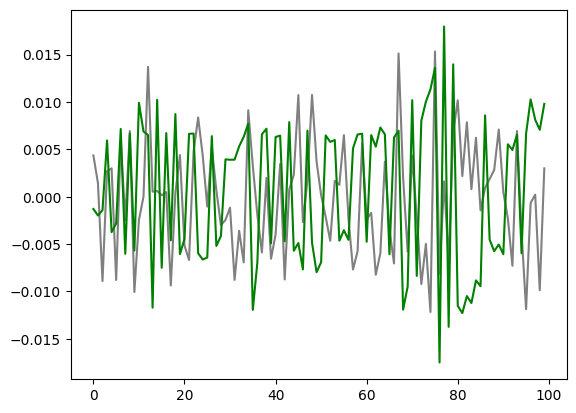

In [ ]:
plt.plot(history, color='grey')
plt.plot(forecast, color='green')
plt.show()

In [ ]:
naive     = [0 for x in range(len(history))]
mae_naive = mean_absolute_error(history, naive)
mae_model = mean_absolute_error(history, forecast)
print('MAE: naive = {:.4f}, model = {:.4f}'.format(mae_naive, mae_model))

MAE: naive = 0.0048, model = 0.0084
